# Hist 3368 - Week 9 - Named Entity Recognition

#### by Jo Guldi, expanding on a prompt from https://www.geeksforgeeks.org/python-named-entity-recognition-ner-using-spacy/

**SPECIAL INSTRUCTIONS FOR THIS SESSION ON M2:**

    For "Memory," put "100GB"

    To the "custom environment settings" space, add this: "source /hpc/applications/python_environments/spacy/bin/activate"

In this notebook, we'll learn how to use the powerful SPACY software library to search for "named entities." 

A ***named entity*** can be a person's name, the name of a country, the date of a famous event, a kind of money, a corporation, or practically anything else. 

 * In the case of this notebook, we'll learn about some of the results of named entity recognition.  We'll see how SPACY categorized named entities as people, places, dates, etc.  

 * We'll then apply SPACY to the Dallas City Council minutes, where we'll see that named entity recognition is capable of detecting the names of local government regulations in Texas
 
 We will notice that the results of grammatical analysis look *very* different from the results of using WordNet.  The controlled vocabulary organized by linguists at Princeton, for example, doesn't know anything about local government regulations in Dallas, Texas.  But by using grammatical analysis, Spacy will pick up on the names of common government regulations specific to Dallas.

#### Using Code to Extract Named Entities

We'll learn about the *Spacy* software package.  To work with Spacy, you need to tell M2 to begin a session with special parameters that include loading the background software for Spacy.

* Please note that to use spaCy on M2 you must go to My Interactive Sessions/JupyterLab and add **source** /hpc/applications/python_environments/spacy/bin/activate to the “Custom environment settings” field.

We'll learn about the

    nlp(string)
    
command from Spacy, which tells spacy to extract all named entities from a string of text.   

We'll also learn how to read the output of the nlp() command, which creates a dataset whose contents are typically called with a for loop requesting each of the following:

    *.ents -- that is, each of the entities for the document created
    *.ent_label_ -- for each entity, there is an ent_label that includes information about what kind of named entity Spacy has found.  

#### Counting Named Entities and Thinking About Counting

We will also see some familiar commands for grouping and counting, which will allow us to model the number of events, persons, corporations, and nationalities mentioned over time with NER.

	.explode().dropna()
	.value_counts()
	.nlargest()
	.groupby()
	.count()
	.unique()

We’ll also talk about the best way of counting over time.  Consider the following propositions.  

If I want to understand the most important places discussed over time in the Dallas City Council debates, should I pay most attention to:

1. the neighborhoods referenced the highest number of months?
2. the neighborhoods that are referenced with the maximum number of times in any single month?
3. the neighborhoods that are referenced the most frequently overall? 

We will give you the code for each of these measurements.

In theory, each of these measurements might contribute to some analysis — the question is how each of them produces a different model of “significance.” 

For instance, the first measure — (1) neighborhoods referenced over the most months — will give you a list of neighborhoods referenced consistently, whereas the second measure — (2) the highest relative peak — will give you neighborhoods that became suddenly important at one moment of time.  Both measures might be potentially useful to know about.  

We will  be asking you to think about how changing what is being measured changes the meaning of the analysis. 

#### Learn How to Write a Function

We'll learn how to define a function, using the command

    def 

and how to return information from a function with the command

    return()

We’ll define a function called ***ner_finder(sentence, Label1)*** -- which will return all the named entities of kind label1 from a string called sentence.  

In theory, ner_finder() can be applied to the text column of any dataset and produce answers, although it is very slow, as is the way with grammatical analysis. The simple formula for applying ner_finder to a column of text, looking only for the items labeled 'LAW', is this:

    results = [ner_finder(sentence, 'LAW') for sentence in dallas_minutes['Text']]

#### Learn Some More About Speed

Finally, this lesson adds a few tools that are useful for speeding up slow code and for estimating how long a coding process will take. These tools, while not essential to the work of this notebook, may be useful as you try to implement code on large-scale datasets.

We’ll learn about speeding up code using “parallel” processing, which is often faster for large datasets than list comprehension.  We’ll learn the function

	.apply()

which "applies" a task over over each item in a list or column -- much like a for-loop. 

To use .apply() with the function ner_finder(), we’ll use the grammar

	.apply(lambda x: [function to be applied])

to apply a function like ner_finder() to each item in a pandas column.



Technically, you don't need to understand .apply() to work with NER.  We'll learn that these two lines of code do *exactly the same thing,* although one may be faster:

    [ner_finder(sentence, 'LAW') for sentence in dallas_minutes['Text']] -- this is the 'list comprehension' method explained above
	dallas_minutes['Text'].apply(lambda x: ner_finder(x, 'LAW')) -- this is the .apply() method 


We’ll learn a little about timing data processes with the **time** package.  We’ll use the command

	time.time() 

To take the time in milliseconds. We'll use this timer to compare the speed of different approaches to the same code. 

This tool will allow you to decide, for yourself, between two comparable coding approaches, choosing the one that is more efficient.





#### Setup Spacy

In [ ]:
import pandas as pd, spacy
from datetime import datetime

In [ ]:
nlp = spacy.load('en_core_web_sm')

Getting an error? 

* Please note that to use spaCy on M2 you must go to My Interactive Sessions/JupyterLab and add **source /hpc/applications/python_environments/spacy/bin/activate** to the **“Custom environment settings”** field.


#### Load some data

We're going to load the speeches of Congress.

In [ ]:
cd /scratch/group/history/hist_3368-jguldi

In [ ]:
congress = pd.read_csv("congress1967-2010.csv")
#congress = pd.read_csv("eighties_data.csv")

In [ ]:
cd ~/digital-history

In [90]:
congress_1968 = congress[congress['year'] == 1968]
congress_1968[:5]

,Unnamed: 0,Unnamed: 0.1,speech,date,speaker,word_count,year,month,month_year
185175,185175,185175,Mr. President. I suggest the absence of a quorum.,1968-01-15,Mr. MANSFIELD,9,1968,1,1968-01-01
185176,185176,185176,The clerk will call the roll.,1968-01-15,The VICE PRESIDENT,6,1968,1,1968-01-01
185177,185177,185177,I announce that the Senator from New Mexico . ...,1968-01-15,Mr. BYRD of West Virginia,200,1968,1,1968-01-01
185178,185178,185178,I announce that the Senator from Massachusetts...,1968-01-15,Mr. KUCHEL,66,1968,1,1968-01-01
185179,185179,185179,A quorum is present.,1968-01-15,The VICE PRESIDENT,4,1968,1,1968-01-01


## Named Entity Recognition with Spacy

The package SPACY uses the grammar of sentences to make an educated "guess" about what kind of entity is under consideration. 

Note that the package *isn't* applying a controlled vocabulary of all possible dates or years. It's just looking at grammar -- using clues like the part-of-speech of each of the words and what prepositions are nearby to make a guess about whether each entity is the name of a law, a place, or a person.

It's actually *generating* a new controlled vocabulary on the basis of grammar.

Named entity recognition can be used as an alternative to controlled vocabulary to create a much more specific, tailor-made vocabulary appropriate to a textbase.  


In [ ]:
sentence = "The United Kingdom passed the Representation of the People Act in 1928, giving women in Wales and London, among others, the right to vote."
  
doc = nlp(sentence)
  
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

Notice that the program has correctly identified a "geo political entity," or GPE, in "The United Kingdom."  It has correctly guessed that we're talking about a law, although it guesses that the name of the law is "the People Act" rather than "The Representation of the People Act."  It notes that the correct year is important, 1928.  

It's important for you to notice that *some of the information is correct* and *some of the information is rather bad*.  As always, you'll need to apply your own best judgment to the situation.

Other things you might be curious about:

 * In the program in question, we're parsing through a list of information called *.ents*, which spacy creates when applying the command **nlp()** to a document. Our document is called called *doc*, so the entities list is called *.ents*.  

 * .ents contains information coded by Spacy as the ".text," or the word that appears to have a significance, the starting character number, the ending character number, and a .label_, which corresponds to a grammatical category such as "date," "law," "geo-political entity," etc.

 * Note: This information is hidden in Spacy's own "Doc" data type.  You don't really need to know anything for our purposes beyond how to call information from a Spacy doc by asking for ent.label_ etc.

Let's try a more complicated sentence. This one mentions nations and people as well as languages.

In [115]:
sentence2 = "In 1066, the Norman leader William the Conquerer -- who came from the north of France -- invaded England at the Battle of Hastings, and his success is the reason why the English language has so many French words in it."
  
doc = nlp(sentence2)
  
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

1066 3 7 DATE
Norman 13 19 NORP
William the Conquerer 27 48 PERSON
France 79 85 GPE
England 97 104 GPE
the Battle of Hastings 108 130 EVENT
English 170 177 LANGUAGE
French 199 205 NORP


Notice that this time we have many more named entities.  Some are classified "DATE" -- like 1066. Others are classified "EVENT" -- like the Battle of Hastings.  We also have a person, William the Conquerer, a LANGUAGE -- English, two nationalities or regional identifications for people (NORP), and two geo-political lentities (French, English).

One could imagine creating a digital history project that investigated any of these categories. For instance, if we were interested in how Congress handled immigration over the twentieth century, it might be interesting to count references to different nationalities and languages.  If we were interested in how Reddit talked about climate change, it might be interesting to track the people and place-names that came up in discussions of environmental contamination.  

However, in this assignment we're going to ask how parliament talked about events and dates.

In [116]:
justevents = []

for ent in doc.ents:
    if ent.label_ == 'EVENT':
        justevents.append(ent.text)
        
justevents

['the Battle of Hastings']

### Apply NER to Congress

Let's apply our event recognizer to just a sample.

In [117]:
congress_1968 = congress_1968.reset_index()
congress_1968['speech'][10]

'Mr. President. is there any rule in the Senate rulebook that requires the Senate. on the opening day of a session. to adjourn without consideration of speeches. resolutions. or petitions that a Senator may deem it his duty. as a Senator representing his State. to present on the floor of the Senate on the opening day of a session?'

Let's do a spacy parse on the speeches from one year.

In [118]:
congress_1968_text = ' '.join([speech for speech in congress_1968['speech']][:500]) # glue together the first 500 speeches

In [119]:
doc = nlp(congress_1968_text) # perform NLP 
  
for ent in doc.ents[:10]: # for each entity found, print the name of the entity, character info, and its category.
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

New Mexico 113 123 GPE
CIXV1Part 143 152 ORG
Indiana 155 162 GPE
Nevada 182 188 GPE
North Dakota 208 220 GPE
Virginia 240 248 GPE
Pennsylvania 268 280 GPE
Tennessee 300 309 GPE
Massachusetts 329 342 GPE
Ohio 362 366 GPE


Let's look for just the dates referenced.

In [120]:
foundlaws = []

for ent in doc.ents:
    if ent.label_ == 'LAW':
        foundlaws.append(ent.text)
        
foundlaws[:10]

['the first amendment of the Constitution',
 'the first amendment of the Constitution of the United States',
 'Constitution',
 'the Constitution of the United States',
 'section 2(b',
 'section 4916',
 'the Internal Revenue Code',
 'section 4911',
 'section 7 of this Act',
 'section 5703']

Change the number in square brackets to see the entire list.

In [121]:
foundpeople = []

for ent in doc.ents:
    if ent.label_ == 'PERSON':
        foundpeople.append(ent.text)
foundpeople[:10]

['Moss',
 'LAUSCHE',
 'Moss',
 'Speaker',
 'H. Res',
 'GERALD',
 'Speaker',
 'H. Res.',
 'Speaker',
 'H. Res']

In [122]:
foundevents = []

for ent in doc.ents:
    if ent.label_ == 'EVENT':
        foundevents.append(ent.text)
        
foundevents[:20]

['World War II',
 'South Vietnam',
 'South Vietnam',
 'South Vietnam',
 'South Vietnam',
 'South Vietnam',
 'South Vietnam',
 'South Vietnam',
 'South Vietnam',
 'South Vietnam',
 'South Vietnam',
 'South Vietnam',
 'South Vietnam',
 'South Vietnam',
 'South Vietnam',
 'World War I.',
 'World War II',
 'World War II',
 'World War II',
 'the First World War']

Let's write a new function.  Functions are defined using the command

    def FUNCTIONNAME(object1, object2):
    
We'll call our new function ner_finder.

It will take two commands: sentence, and label1.

It will return any matches for a sentence and a label. To tell Python what to return to the user after running a function, we use 

    return()
    

In [123]:
def ner_finder(sentence, label1):
    
    doc = nlp(sentence)
    
    foundstuff = []

    for ent in doc.ents:
        if ent.label_ ==  label1:
            foundstuff.append(ent.text)
    
    return(foundstuff)

Let's try out our new function on some of the categories that Spacy can detect:

In [124]:
geopolitical = ner_finder(congress_1968_text, 'GPE')
geopolitical[:10]

['New Mexico',
 'Indiana',
 'Nevada',
 'North Dakota',
 'Virginia',
 'Pennsylvania',
 'Tennessee',
 'Massachusetts',
 'Ohio',
 'New Hampshire']

In [125]:
laws = ner_finder(congress_1968_text, 'LAW')
laws[:10]

['the first amendment of the Constitution',
 'the first amendment of the Constitution of the United States',
 'Constitution',
 'the Constitution of the United States',
 'section 2(b',
 'section 4916',
 'the Internal Revenue Code',
 'section 4911',
 'section 7 of this Act',
 'section 5703']

In [126]:
people = ner_finder(congress_1968_text, 'PERSON')
people[:10]

['Moss',
 'LAUSCHE',
 'Moss',
 'Speaker',
 'H. Res',
 'GERALD',
 'Speaker',
 'H. Res.',
 'Speaker',
 'H. Res']

In [127]:
places = ner_finder(congress_1968_text, 'LOC')
places[:10]

['Pacific',
 'Pacific',
 'the South Pacific',
 'Congressional District of Missouri',
 'Eighth District',
 'Americas',
 'H.R. 6649',
 'H.R. 6649',
 'Africa',
 'East']

In [128]:
dates = ner_finder(congress_1968_text, 'DATE')
dates[:10]

['the opening day',
 'day',
 'the opening day',
 'the opening day',
 'the opening days',
 'the first day',
 'the opening day',
 'today',
 'today',
 'today']

In [129]:
organizations = ner_finder(congress_1968_text, 'ORG')
organizations[:10]

['CIXV1Part',
 'Chair',
 'Senate',
 'Senate',
 'Senate',
 'Nation',
 'Chair',
 'Senate',
 'Senate',
 'State']

In [130]:
events = ner_finder(congress_1968_text, 'EVENT')
events[:10]

['World War II',
 'South Vietnam',
 'South Vietnam',
 'South Vietnam',
 'South Vietnam',
 'South Vietnam',
 'South Vietnam',
 'South Vietnam',
 'South Vietnam',
 'South Vietnam']

## Named Entity Recognition with Tabular Data

Now let's apply the spacy *nlp* command to everything in the 'Text' column. The formula that we used above was 

    nlp(sentence)

This time, however, we want to apply *nlp()* to every row in a pandas dataframe.   Here's one way of writing such a command:

    dallas_minutes['NLP'] = [ner_finder(sentence, 'LAW') for sentence in dallas_minutes['Text']]

In [131]:
sample = [ner_finder(speech, 'LAW') for speech in congress_1968['speech'][:20]]
sample

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['the first amendment of the Constitution',
  'the first amendment of the Constitution of the United States'],
 ['Constitution'],
 [],
 []]

Youll see a series of blank entries -- [] -- which represent rows in the database, or congressional speeches, where no mentions of concrete laws were detected.  You'll also see a few references to the Constitution.  These correspond to the speeches in our list of Congressional speeches from the year 1968.  We can use the order of the speeches to work with extra information about the speeches' date of delivery, the speaker who gave them, and other important facts.

Let's run the same command again, but this time save it as a new column called 'law,' so that we can see the speaker, date of delivery of the speech, and other information.

In [ ]:
#sample = congress_1968[:100].copy()
#congress_1968_ner = congress_1968_small.copy()
#congress_1968_ner['law'] = [ner_finder(speech, 'LAW') for speech in congress_1968['speech']] # downsampled --  alter the number in brackets or delete it to do more debates
#congress_1968_ner[:20]

(actually, that takes about an hour, so let's just load some pre-made data)

In [145]:
cd /scratch/group/history/hist_3368-jguldi

/scratch/group/history/hist_3368-jguldi


In [149]:
named_entities1 = pd.read_csv("named-entities-per-month-for-congress-1967-2010LAW.csv")

In [153]:
congress_1968_ner = named_entities1[named_entities1['year'] == 1968]
congress_1968_ner['law'] = named_entities1['stuff']
congress_1968_ner.head()

/hpc/applications/python_environments/spacy/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,speech,date,speaker,word_count,year,month,month_year,stuff,law
24389,185191,185191,185191,I wish to advise the Vice President. the Presi...,1968-01-15,Mr. MORSE,193,1968,1,1968-01-01,the first amendment of the Constitution,the first amendment of the Constitution
24390,185191,185191,185191,I wish to advise the Vice President. the Presi...,1968-01-15,Mr. MORSE,193,1968,1,1968-01-01,the first amendment of the Constitution of the...,the first amendment of the Constitution of the...
24391,185192,185192,185192,The Chair knows of no such rule. which would s...,1968-01-15,The VICE PRESIDENT,13,1968,1,1968-01-01,Constitution,Constitution
24392,185248,185248,185248,Mr. Speaker. we are starting on a new year. I ...,1968-01-15,Mr. JONES of Missouri,364,1968,1,1968-01-01,the Constitution of the United States,the Constitution of the United States
24393,185269,185269,185269,Mr. Speaker. for the benefit of all the Member...,1968-01-15,Mr. PATMAN,1044,1968,1,1968-01-01,section 2(b,section 2(b


You might also notice that the code hangs for a moment.  *Give the computer a while to do its work.*

  * Spacy is an intensive software package, and applying nlp() to many documents can be slow going. Remember how a similarly linguistically-intense command, wn.morphy(), slowed us down elsewhere.
  * If you'd like to think about speeding up your code, please consult the "Tutorial on Speed" in the Github.


Next, let's filter for JUST the NLP findings that are events.

### Find the laws most frequently mentioned overall

To work with the laws in the law column, we should also notice that the 'law' column we've just made is filled with list.  If multiple laws are referenced within the same speech, the 'law' column lists multiple laws, strung together as a list inside square brackets, whose members are separated by commas:

    [the Constitution, Constitution, the Internal Revenue Code]

If we want to count like mentions of laws, we'll need to split up this data so that each item in the list gets its own row.  We will follow a basic procedure to work with this data:

* In order to count items in a list, we *explode* the list so that each list item gets its own row.  
* Then we can use *.value_counts()* to count how many times each appears.
* We can use *.nlargest()* to get the most frequent items.

#### Use *.explode()* to reformat the data so that each entity gets its own row

We can use *.explode()* and *.groupby()* to tell pandas how to organize the data before using *.count()* to tell us how many laws are mentioned in each grouping.

  * Let's "explode" the data so that every law gets its own row. 
  * Let's group by *Month-Year* and *Laws* so that we bundle under each month-year each mention of a law mentioned in that time period.  
  * We'll use square brackets around 'Laws' once more to tell pandas that we're interested in just working with the *Laws* column. 
  * We'll apply *.count()* to count ***how many laws are mentioned per Month-Year.*** This is what we really want to know.

First, 'explode' the data.

In [154]:
congress_1968_law_exploded = congress_1968_ner.explode('law').dropna()
congress_1968_law_exploded[:5]

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,speech,date,speaker,word_count,year,month,month_year,stuff,law
24389,185191,185191,185191,I wish to advise the Vice President. the Presi...,1968-01-15,Mr. MORSE,193,1968,1,1968-01-01,the first amendment of the Constitution,the first amendment of the Constitution
24390,185191,185191,185191,I wish to advise the Vice President. the Presi...,1968-01-15,Mr. MORSE,193,1968,1,1968-01-01,the first amendment of the Constitution of the...,the first amendment of the Constitution of the...
24391,185192,185192,185192,The Chair knows of no such rule. which would s...,1968-01-15,The VICE PRESIDENT,13,1968,1,1968-01-01,Constitution,Constitution
24392,185248,185248,185248,Mr. Speaker. we are starting on a new year. I ...,1968-01-15,Mr. JONES of Missouri,364,1968,1,1968-01-01,the Constitution of the United States,the Constitution of the United States
24393,185269,185269,185269,Mr. Speaker. for the benefit of all the Member...,1968-01-15,Mr. PATMAN,1044,1968,1,1968-01-01,section 2(b,section 2(b


 #### Use *.groupby()* and *.count()* to Count How Many Time Each Law is Mentioned Overall 

This line of code "groups" the data by the law referenced in the "law" column, then "counts" how many times each law was mentioned.

In [155]:
law_counts = congress_1968_law_exploded.groupby(['law'])['law'].count() # count how many laws there are

Minor reformatting gives us the answers we want with nicely labeled columns.

In [156]:
law_counts = pd.DataFrame(law_counts) # convert from Series to DataFrame
law_counts.columns = ['count'] # label the one column "count"
law_counts = law_counts.reset_index().sort_values('count', ascending = False) # turn the multi-index into columns 'year' and 'vocab'
law_counts[:5]

,law,count
356,Constitution,2039
3188,the Constitution,448
3131,the Civil Rights Act,245
58,ABM,227
862,Public Law 874,215


Grab just the top laws

In [157]:
top_laws = law_counts[:20]
top_laws

,law,count
356,Constitution,2039
3188,the Constitution,448
3131,the Civil Rights Act,245
58,ABM,227
862,Public Law 874,215
3675,the Internal Revenue Code,208
3207,the Constitution of the United States,208
3580,the Higher Education Act,205
792,Public Law 480,190
1843,United States Code,173


 #### Use *.groupby() and *.count()* to Count Laws Mentioned by Month

First, let's "group" by month and law and "count" how many times each law is mentioned in each month. 

In [158]:
law_per_month_counts = congress_1968_law_exploded.groupby(['month_year', 'law'])['law'].count() # count how many unique months correspond to each law

Minor reformatting.

In [159]:
law_per_month_counts = pd.DataFrame(law_per_month_counts) # convert from Series to DataFrame
law_per_month_counts.columns = ['count'] # label the one column "count"
law_per_month_counts = law_per_month_counts.reset_index() # turn the multi-index into columns 'year' and 'vocab'
law_per_month_counts = law_per_month_counts.sort_values('count', ascending = False) # sort by 'count'
law_per_month_counts[:5]

,month_year,law,count
2468,1968-05-01,Constitution,536
5840,1968-09-01,Constitution,389
21,1968-01-01,Constitution,183
4251,1968-07-01,Constitution,181
485,1968-02-01,Constitution,174


What are the laws talked about each month *most frequently*?

In [160]:
top_laws_per_month = law_per_month_counts.groupby(['month_year']).apply(lambda x: x.sort_values('count', ascending = False)).reset_index(drop=True)
top_laws_per_month = top_laws_per_month.groupby('month_year').head(3)
top_laws_per_month[:20]        

,month_year,law,count
0,1968-01-01,Constitution,183
1,1968-01-01,the Constitution,45
2,1968-01-01,the Social Security Act,44
447,1968-02-01,Constitution,174
448,1968-02-01,the Constitution,44
449,1968-02-01,the Civil Rights Act,29
1133,1968-03-01,Constitution,120
1134,1968-03-01,the Constitution,39
1135,1968-03-01,Public Law 874,38
1767,1968-04-01,Constitution,104


#### Filter for the Most Important Laws

There are multiple ways of going about the next step, but we'll show one.  Let's connect this data about the most talked-about laws to our data about dates, in the dataframe laws_per_month.

Notice the use of .index, .isin(), and [] to filter for a certain condition.

Let's find the top laws by the maximum count per month:

In [161]:
top_laws_with_month = law_per_month_counts[law_per_month_counts['law'].isin(top_laws['law'])].sort_values('count', ascending = False) # find top laws over time
top_laws_with_month[:3]

,month_year,law,count
2468,1968-05-01,Constitution,536
5840,1968-09-01,Constitution,389
21,1968-01-01,Constitution,183


Let's do some minor reformatting of the Month-Year from string into datetime() data so that the graph will display correctly.

In [162]:
#unnecessary?
#top_laws_per_month['month_year_'] = pd.to_datetime(top_laws_per_month['month_year'], format='%m-%y', errors='coerce')
#top_laws_per_month[:5]

#### Plotting a Graph of Named Entities Over Time

<Figure size 432x288 with 0 Axes>

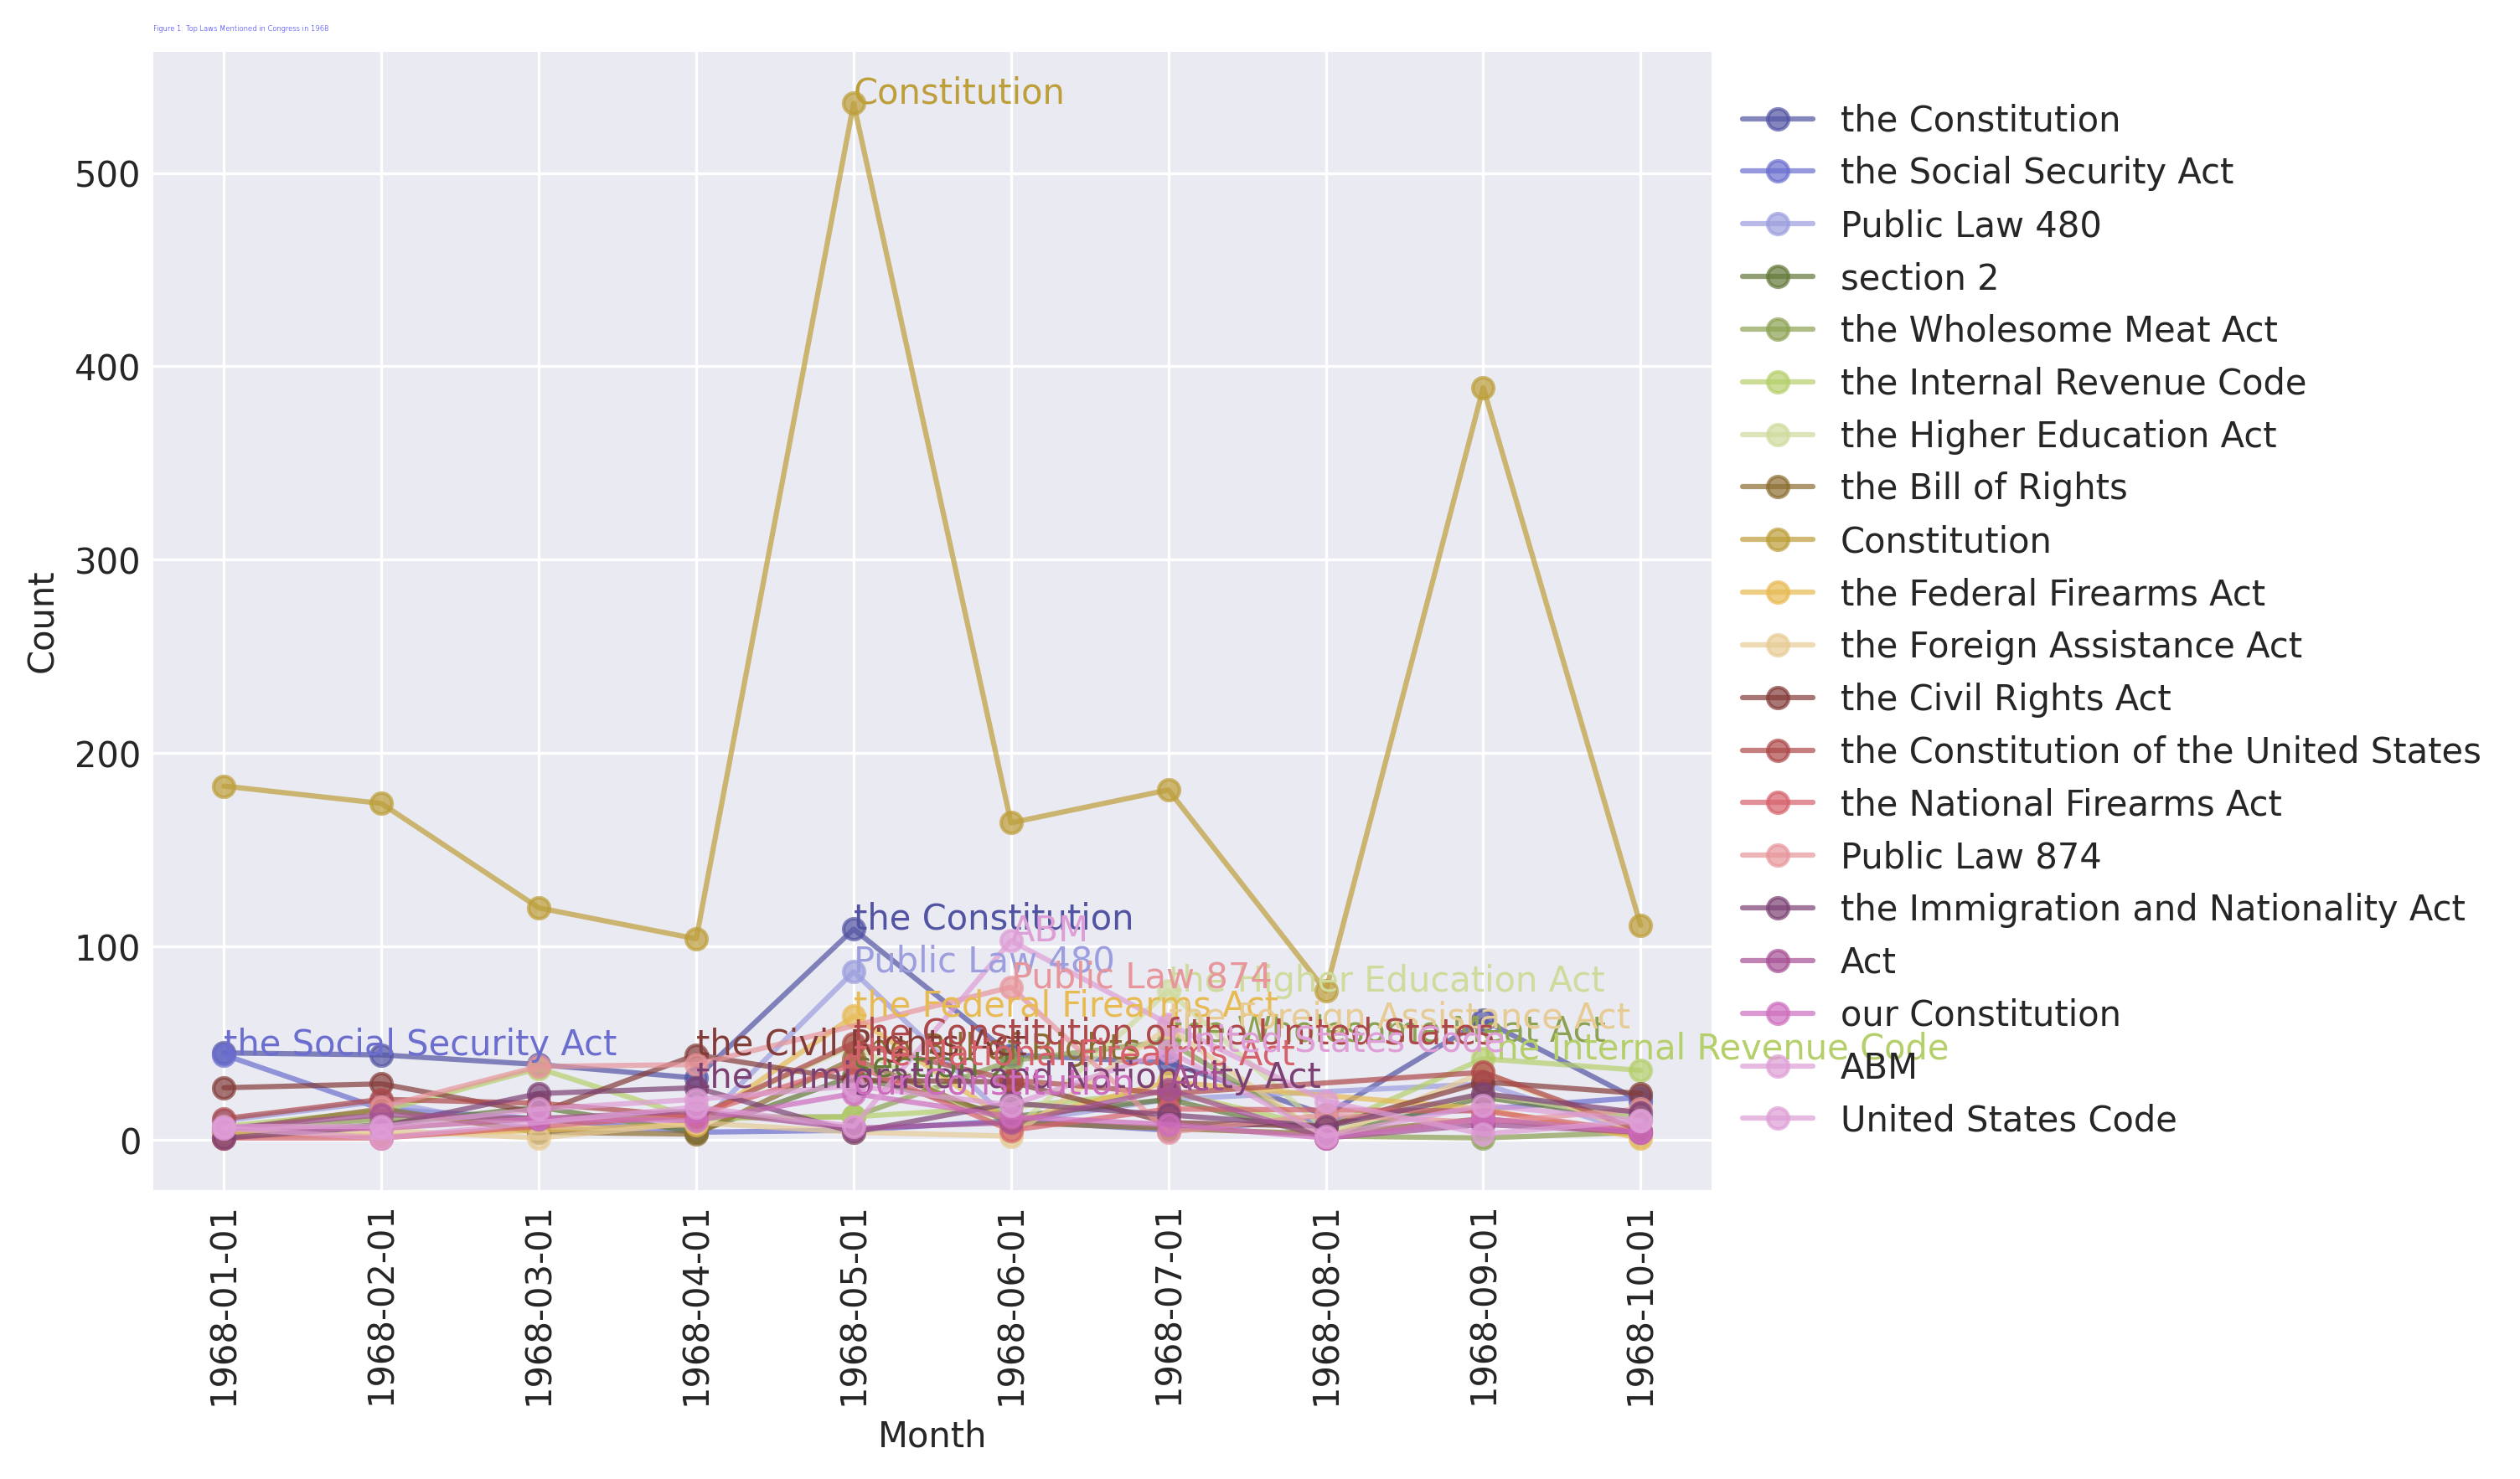

<Figure size 432x288 with 0 Axes>

In [169]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import random


%matplotlib inline

figure(figsize=(8, 6), dpi=300)

plt.style.use('seaborn-darkgrid') # this gives us a grid with a dark background.  you can play with this to change the style.
palette = plt.get_cmap('tab20b') # this tells matplotlib what colors to use.  you can play with this to change the colors.
num=0

for entity in set(top_laws_with_month['law']): # one loop for each color/line
        
        # get points
        num+=1 # for each new word, the counter 'num' changes 
        x = top_laws_with_month.loc[top_laws_with_month['law'] == entity, 'month_year'] # x points
        y = top_laws_with_month.loc[top_laws_with_month['law'] == entity, 'count'] # y points
        x2, y2 = zip(*sorted(zip(x, y))) # get everything in the right order
        
        # make a line
        plt.plot(x2, # x axis 
             y2,  # y axis
             '-o', # make dots with lines
             color=palette(num), alpha=0.7, label=entity) # num tells the plot to choose a different color this time
        
        # make labels
        y3 = max(y2) # label lines at their highest point
        entity_points = top_laws_with_month[top_laws_with_month['law'] == entity]
        x3 = random.choice(entity_points[entity_points['count'] == max(entity_points['count'])]['month_year'].tolist()) # more for finding the highest point
        plt.text(x3, y3, entity, color = palette(num), size = 10) # this is the code to supply a label for each line

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # move the legend
plt.xticks(rotation=90)
plt.title("Figure 1: Top Laws Mentioned in Congress in 1968", loc='left', fontsize=2, fontweight=5, color='Blue')
plt.xlabel("Month")
plt.ylabel("Count")
plt.figure()


Note that for the purposes of clarifying what the graph is showing, I've used "plt.text()" to create a label for each line, and assigned that label the same color as each line.  Notice that I've also used the argument "bbox_to_anchor" for the legend to move the legend to the left of the chart.

*The output is far from ideal.*  I would much prefer to see a graph where the labels aren't overlapping (there is a module for this called adjust_text, which we'll explore later)

But the point of this exercise is to show one possible strategy for making charts clearer and more intuitive.

It will be the responsibility of each student group to decide on the appropriate strategy for each data set.  An appropriate strategy is one that shows you pertinent information and which is legible.

## Using NER for historical research

### Look for word1

Let's talk about how to dive deeper into research.

First, define the word or phrase that you want to look for.

In [40]:
word1 = "the Constitution"

We learned that we can use **str.count()** to count the individual occurrences of a word per speech. str.count() takes one object, the word you're looking for. We're looking for *word1*, which is a variable containing the word 'malpractice.'

We can also use **.sort_values()** to tell pandas to sort the data by the values in one column.  .sort_values() takes the arguments "by" (where you tell it which column to use, using quotation marks, and "ascending," which can be True or False, depending on how you want your values arranged.

In [41]:
congress_1968['keywordcount'] = congress_1968['speech'].str.count(word1)
congress_1968.sort_values(by = 'keywordcount', ascending = False)[:5]

,index,Unnamed: 0,Unnamed: 0.1,speech,date,speaker,word_count,year,month,month_year,keywordcount
119439,304614,304614,304614,Mr. President. the constitution of my native S...,1968-08-02,Mr. ERVIN,8652,1968,8,1968-08-01,65
58751,243926,243926,243926,Mr. President. article V of the Constitution p...,1968-05-14,Mr. ERVIN,2742,1968,5,1968-05-01,45
135955,321130,321130,321130,Mr. President. the good and wise men who fashi...,1968-09-27,Mr. ERVIN,5204,1968,9,1968-09-01,44
123116,308291,308291,308291,The Washington Post. Washington. D.C. DEAR SI:...,1968-09-09,The EDITOR,3028,1968,9,1968-09-01,38
8064,193239,193239,193239,Mr. President. William Gladstone said that the...,1968-02-02,Mr. ERVIN,3186,1968,2,1968-02-01,26


How many times was the word 'malpractice' used in each time period?

In [42]:
congress_1968['speech'].str.count(word1).sum()

2652

In [46]:
may_1968 = congress_1968[congress_1968['month'] == 5]
august_1968 = congress_1968[congress_1968['month'] == 8]

In [47]:
may_1968['speech'].str.count(word1).sum()

704

In [48]:
august_1968['speech'].str.count(word1).sum()

88

What does the difference mean?  Read for a little context:

 [https://en.wikipedia.org/wiki/May_1968](https://en.wikipedia.org/wiki/May_1968)
 
 [https://en.wikipedia.org/wiki/1968_Democratic_National_Convention](https://en.wikipedia.org/wiki/1968_Democratic_National_Convention)

### Get the context for word1

To get the context for word1, you must call up the full text for the speeches where the keyword appears.

Next, we can count the words that commonly appear around word1.

Using .str.count(word1) and .nlargest(n) give you a list of the rownumbers for the n speeches where word1 appears the most frequently.  The rownumbers are stored in the .index for the resulting series. We save the results as the variables *word1_speechnumbers*

We can use .loc() and the rownumbers to call up the full text of the speeches that correspond to word1_speechnumbers.  We will save the results as *word1_context.*

We then clean the data using stopwording, lowercasing, and punctuation stripping.

We then count the words that result using commands for breaking the string into words, giving each word a separate row, dropping empty rows, and counting the results:

    str.split().explode().dropna().value_counts()
    
    

In [53]:
en = spacy.load('en_core_web_sm')
stop = en.Defaults.stop_words

In [54]:
stopwords_regex = r'\b(?:{})\b'.format('|'.join(stop))

In [55]:
# get the rownumbers of the n speeches that use word1 the most
word1_may_speechnumbers = may_1968['speech'].str.count(word1).nlargest(10) 
word1_august_speechnumbers = august_1968['speech'].str.count(word1).nlargest(10) 

# get the speeches that mentioned word1 the most
word1_may_context = may_1968.loc[list(word1_may_speechnumbers.index)]
word1_august_context = august_1968.loc[list(word1_august_speechnumbers.index)]
                                
# clean up the data
word1_may_context['cleanspeech'] = word1_may_context['speech'].str.replace('[^\w\s]','').str.lower() # remove punctuation, lowercase
word1_may_context['stopworded'] = word1_may_context['cleanspeech'].str.replace(stopwords_regex, '') #stopwording

word1_august_context['cleanspeech'] = word1_august_context['speech'].str.replace('[^\w\s]','').str.lower() # remove punctuation, lowercase
word1_august_context['stopworded'] = word1_august_context['cleanspeech'].str.replace(stopwords_regex, '') #stopwording

In [58]:
# count the other words that appear in the context of word1 in 1967
word1_may_context_count = word1_may_context["stopworded"].str.split().explode().dropna().value_counts()
word1_may_context_count[:20]

court           345
constitution    216
supreme         212
case            178
law             137
jurisdiction    115
state           110
states          110
justice         103
cases            98
congress         98
power            85
crime            83
shall            83
courts           80
title            78
federal          77
miranda          75
united           72
decision         71
Name: stopworded, dtype: int64

In [59]:
# count the other words that appear in the context of word1 in 1967
word1_august_context_count = word1_august_context["stopworded"].str.split().explode().dropna().value_counts()
word1_august_context_count[:20]

court             169
supreme           104
constitution       95
states             73
power              65
constitutional     51
congress           51
amendment          48
government         47
state              43
justice            43
judicial           40
united             39
national           38
case               38
law                36
right              34
guard              34
president          31
decisions          29
Name: stopworded, dtype: int64

### Inspect the data for the word 'malpractice' in 1967

We can call up *word1_1967_speechnumbers* and find out how frequently 'malpractice' was mentioned in 1967.

In [60]:
word1_may_speechnumbers

58751    45
55468    26
55464    24
61959    23
55487    16
67075    11
61868    10
62522     9
50489     8
62186     8
Name: speech, dtype: int64

Look at the speech that mentions word1 the most (use the index number to the left)

Who gave the speech?

In [61]:
word1_may_context['speaker'][58751][:1000]

'Mr. ERVIN'

What did the speech say?

In [62]:
word1_may_context['speech'][58751][:1000]

'Mr. President. article V of the Constitution provides as follows: The Congress. whenever two thirds of both Houses shall deem it necessary. shall propose Amendments to this Constitution. or. on the Application of the Legislatures of two thirds of the several States. shall call a Convention for proposing Amendments. which. in either Case. shall be valid to all Intents and Purposes. as Part of this Constitution. when ratified by the Legislatures of three fourths of the several States. or by Conventions in three fourths thereof. as the one or the other Mode of Ratification may be proposed by the Congress. Provided that no Amendment which may be made prior to the Year One thousand eight hundred and eight shall in any Manner affect the first and fourth Clauses in the Ninth Section of the first Article. and that no State. without its Consent. shall be deprived of its equal Suffrage in the Senate. In discussing this article in the Federalist. James Madison said that the Constitutional Conven

I've cut the quote short.  You can see the whole speech for yourself by deleting the [:1000] at the end of the line of code.


#### The importance of keeping going

Keep going until you understand! You'll want to quote the evidence you gather.  Note that these speeches are selected at random from the list of speechnumbers that appear in the dataset.


In [63]:
word1_may_context['speech'][55468]

'Mr. President. I now read this passage from volume I of the commentary on the Constitution of the United States written by Bernard Schwartz. on page 375: What the appellate powers of the Supreme Court shall be. declares Chief Justice Waite (in what has been termed the Courts strongest pronouncement on the extent of Congressional control over its appellate jurisdiction). "and to what extent they shall be exercised are. and always have been. proper subjects of legislative control. Authority to limit the jurisdiction necessarily carries with it authority to limit the use of the jurisdiction. Not only may whole classes of cases be kept out of the jurisdiction altogether. but particular classes of questions may be subjected to reexamination and review. while others are not." Under this approach. it is for the Congress to determine how far appellate jurisdiction shall be given and. when conferred. it can be exercised only to the extent and in the manner prescribed by statute. In Justice Fra

Use command-F or EDIT > FIND in the menu above to search for word1 in your screen until you see the context.  


### Inspect the data for word1 in August

Let's look at word1 in August

In [64]:
word1_august_speechnumbers

119439    65
120835     9
120401     2
120588     2
120743     2
117891     1
117933     1
117943     1
118124     1
120465     1
Name: speech, dtype: int64

We saw above that the word "malpractice" was invoked far more frequently in 2010 than in 1967.  Here, we see that the speeches that invoked 'malpractice' in 2010 also invoke that term more frequently -- up to 7 times in one speech -- than the one or two times each speech used the term in 1967.  

Such a shift suggests that the word 'malpractice' is being applied with a more specific meaning in 2010. But to interpret this shift, we need to read more.

Let's look at the top speech, from row 7016.  Who gave the speech?.

In [65]:
word1_august_context['speaker'][119439]

'Mr. ERVIN'

What did the speech say?

In [66]:
word1_august_context['speech'][119439]

'Mr. President. the constitution of my native State of North Carolina has always contained a warning which all Americans would do well to heed. It is this: A frequent recurrence to fundamental principles is absolutely necessary to preserve the blessings of liberty. Let us pause for a few moments. and recur to some fundamental principles. The men who composed the Constitutional Convention of 1787 were wise men. They had read the history of the long and bitter struggle of man for freedom. and had found this shocking but everlasting truth inscribed upon each page of that history: No man or set of men can be safely trusted with governmental power of an unlimited nature. As a consequence. they were determined. above all things to establish a government of laws and not of men. To prevent the exercise of arbitrary power by the Federal Government. they embodied in the Constitution the doctrine of the separation of governmental powers. In so doing. they utilized this doctrine in a twofold way. 

### Perform the same search with new vocabulary

When you research shifts in words, typically you won't work on a single word at a time. You'll begin with a controlled vocabulary of the kind we used to investigate discussions of crime in Congress last week. Then you'll narrow down to a few words whose meaning you need to understand better.

We can use a 'for' loop to cycle through a dozen words very quickly, producing an analysis.  

We can even add a few lines to this for loop to ask the computer to print out all the relevant speeches.  I have abbreviated the number of words listed and the lines of the speeech given for room.

When you do your assignment, begin by zeroing in on certain words in the list of keywords on the first line.  

Next, tweak the code to show more words and lines of the speech when you get to your own research.



In [68]:
top_laws[:10]

,law,count
35,Constitution,229
389,the Constitution,62
544,the Social Security Act,56
1,14th amendment,47
523,the Railroad Retirement Act,44
442,the Fourteenth Amendment,37
379,the Civil Rights Act,34
317,section 5,20
551,the TaftHartley Act,18
353,the 14th amendment,16


In [70]:
for word1 in top_laws['law'][:10]:
    
  # get the rownumbers of the n speeches that use word1 the most
    word1_may_speechnumbers = may_1968['speech'].str.count(word1).nlargest(2)  ########### <-- play with this number *********
    word1_august_speechnumbers = august_1968['speech'].str.count(word1).nlargest(2)  ########### <-- play with this number *********

    # get the speeches that mentioned word1 the most
    word1_may_context = may_1968.loc[list(word1_may_speechnumbers.index)]
    word1_august_context = august_1968.loc[list(word1_august_speechnumbers.index)]

    # clean up the data
    word1_may_context['speech'] = word1_may_context['speech'].str.replace('[^\w\s]','').str.lower() # remove punctuation, lowercase
    word1_may_context['stopworded'] = word1_may_context['speech'].str.replace(stopwords_regex, '') #stopwording

    word1_august_context['speech'] = word1_august_context['speech'].str.replace('[^\w\s]','').str.lower() # remove punctuation, lowercase
    word1_august_context['stopworded'] = word1_august_context['speech'].str.replace(stopwords_regex, '') #stopwording

    # print some context for May
    print("*****")
    print("CONTEXT for "+word1+" in May 1968")
    for speechnumber in list(word1_may_speechnumbers.index)[:2]:  ########### <-- play with this number *********
        speaker = may_1968['speaker'][speechnumber]
        date = may_1968['date'][speechnumber]
        print('speech by '+ speaker + ' in ' + date)
        print(may_1968['speech'][speechnumber][:100])  ########### <-- play with this number *********

    # count the other words that appear in the context of word1 in May
    word1_may_context_count = word1_may_context["stopworded"].str.split().explode().dropna().value_counts()
    print("***")
    print("COLLOCATES for " + word1 + " in May 1968")
    print(word1_may_context_count[:5])  # <-- play with this number

    # print some context for August
    print("*****")
    print("CONTEXT for "+ word1+" in August 1968")
    for speechnumber in list(word1_august_speechnumbers.index)[:2]:  ########### <-- play with this number *********
        speaker = august_1968['speaker'][speechnumber]
        date = august_1968['date'][speechnumber]
        print('speech by '+ speaker+ ' in ' + date)
        print(august_1968['speech'][speechnumber][:100])  ########### <-- play with this number *********

    # count the other words that appear in the context of word1 in 2010
    word1_august_context_count = word1_august_context["stopworded"].str.split().explode().dropna().value_counts()
    print("COLLOCATES for " + word1 + " in August 1968")
    print(word1_august_context_count[:5])   ########### <-- play with this number *********

*****
CONTEXT for Constitution in May 1968
speech by Mr. ERVIN in 1968-05-14
Mr. President. article V of the Constitution provides as follows: The Congress. whenever two thirds 
speech by Mr. ERVIN in 1968-05-09
Mr. President. I now read this passage from volume I of the commentary on the Constitution of the Un
***
COLLOCATES for Constitution in May 1968
court           77
constitution    77
case            62
supreme         49
miranda         39
Name: stopworded, dtype: int64
*****
CONTEXT for Constitution in August 1968
speech by Mr. ERVIN in 1968-08-02
Mr. President. the constitution of my native State of North Carolina has always contained a warning 
speech by Mr. ERVIN in 1968-08-02
Mr. President. article II of the Constitution expressly provides that the President may appoint a Su
COLLOCATES for Constitution in August 1968
court             163
supreme            98
constitution       83
power              56
constitutional     47
Name: stopworded, dtype: int64
*****
CONTEXT for

## Implementing KeyWords in Context (KWIC)

For this last exercise we will find keywords in context (KWIC). You can think of KWIC's output like the lines of a concordance, where you look up a passage and find the context.  We saw in the reading that historian Luke Blaxill used KWIC to make arguments about how different words were used in British election speeches.

KWIC is not the only view you need to understand the context of speeches, but it is a useful one.

To produce this output, we will split the text into n-grams where "n" stands for any number. For example, a text split into single words (like our data frame in the previous example) is split into 1-grams (also just called "tokens"). 3-grams split the text into units that are 3 words long. 5-grams split the text into units that are 5 words long. 

Now let's write a function that returns our keyword in context. You don't need to follow the code, but you should know that you can always use the function below when you want to generate a KWIC view.

In [72]:
keyword = 'Constitution'

keyword_df = may_1968[may_1968['speech'].str.contains(keyword)].copy() # search the text for the presence of our keyword 

def KWIC(body):
    n = 5 # specify the number of surrounding words to use before and after the keyword
    
    words = body.split() # split the words into tokens
    keyword_index = 0
    
    # The following for loop iterates through each word in the text. If our keyword is found, the for loop stores its index. 
    # But, why are we storing the index? As you might remember, the index is a numerical representation of the row's position.
    # It can also be thought of as a unique name the computer uses to identify a row. We can call the index to return JUST these rows.
    for index, word in enumerate(words): 
        if keyword in word: 
            keyword_index = index
            break
    
    before_keyword = words[max(0, keyword_index - n):keyword_index] # store the words that come before the keyword, up to our specified number 
    after_keyword = words[keyword_index:keyword_index + n] # store the words that come after the keyword, up to our specified number 
    return ' '.join(before_keyword + after_keyword) # return the keyword in its context

keyword_df['context'] = keyword_df['speech'].apply(KWIC)

In [73]:
keyword_df[['context']]

,context
50430,first 10 amendments to the Constitution. known...
50435,the 55 members of the Constitutional Conventio...
50489,the Supreme Court amended the Constitution by ...
50491,incorporate this notion into the Constitution ...
50494,observe consistent with the Federal Constituti...
...,...
69885,the fifth amendment to the Constitution of the...
70383,of speech provision of the Constitution. I hop...
70536,of Rights in the U.S. Constitution. The poor p...
70897,defend our lives and our Constitution. The mil...


This data frame is a little difficult to look at, so I am going to export the contents to a file.  You can find this file in the left-hand sidebar of Jupyter and open it on your home computer to inspect later via an application such as excel.

In [75]:
keyword_df['context'].to_csv('KWIC_example_keyword_constitution_may_1968.csv', sep = ' ', index=False, header = True)

## Optional Section

## Let's return to extracting named entities. Let's make it faster and more efficient.

We'd probably like to search for multipe categories.  

Let's create a function that will apply named entity recognition for a single category, count the stuff over months, find the stuff mentioned over multiple months, and plot it in a line chart.

First, let's just run the named entity recognizer one more time over our data to get a list of all possible named entities.

 ***This may take some time. Give it an hour or downsample.***

Here is the basic code to extract named entities from each speech for Congress in the year 1968.  

    named_entities1 = [nlp(doc) for doc in congress_1968['speech']]
    
-- or with .apply:

    named_entities1 = congress_1968['speech'].apply(lambda x: nlp(x))
    
Both will get you to the same place. 

Below, we add some fancy new functions to (1) parallelize for speed and (2) add a progress report that will tell us how far we are through the corpus.  You do not need to know how the code works; just enjoy the power!

#### Processing Over All of 1968 with a Progress Bar

In [ ]:
def logged_apply(g, func, *args, **kwargs):
    step_percentage = 100. / len(g)
    import sys
    sys.stdout.write('apply progress:   0%')
    sys.stdout.flush()

    def logging_decorator(func):
        def wrapper(*args, **kwargs):
            progress = wrapper.count * step_percentage
            progress1 = round(progress, 3)
            if (progress *100000) % 10000 == 0:  
                sys.stdout.write('\033[D \033[D' * 4 + format(progress, '3.0f') + '%')
            sys.stdout.flush()
            wrapper.count += 1
            return func(*args, **kwargs)
        wrapper.count = 0
        return wrapper

    logged_func = logging_decorator(func)
    res = g.apply(logged_func, *args, **kwargs)
    sys.stdout.write('\033[D \033[D' * 4 + format(100., '3.0f') + '%' + '\n')
    sys.stdout.flush()
    return res

In [ ]:
named_entities1 = logged_apply(congress_1968['speech'], lambda x: nlp(x))

#### Processing in Parallel With Multiple Cores

In [113]:
import multiprocessing
import numpy as np
from multiprocessing import Pool
import marshal

n = multiprocessing.cpu_count()

def parallelize_operation(df, func, n_cores = n):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

def lambda_nlp(df): 
    out = df.apply(nlp)
    return out

In [ ]:
named_entities1 = parallelize_operation(congress_1968['speech'], lambda_nlp)

#### A Function to Do Our Counting and Mapping

Let's define a function, ner_mapper.

The point of our creating a function here is to show that we can recapitulate all of the code in this notebook, starting with the original dataframe, in such a way that we can efficiently mine the text for multiple kinds of named entity (ORG, GPE, PERSON, etc), thus allowing us to make multiple graphs.

Following the line beginning with "def", all of the code *inside* the function is code that you have seen before.  

Here is what happens.

In the line beginning with "def," we define a new function, naming it, ner_mapper.  We also tell Python that our new function will take three objects:

   * dataframe1 - a dataframe with column "Month-Year"
   * column1 - a parsed column of named entities, corresponding to the "text" column of dataframe1
   * label1 - a label of Spacy named entity categories, for example 'GPE' or 'ORG'
   
Inside the function:

   * We filter just for the named entities that match label1.
   * We group those named entities by month-year and count how many there are.
   * We find the named entities that are spoken about over 3 months or more.
   * We plot a line graph showing those named entities over time.
   * We save the figure.


In [83]:
import numpy as np
import random
import matplotlib.pyplot as plt
palette = plt.get_cmap('tab20b') # this tells matplotlib what colors to use.  you can play with this to change the colors.

In [84]:
def ner_mapper(dataframe1, column1, label1):
    
    print('*****************')
    print('LOOKING FOR ', label1)
    print('**')
    
    # filter only for the named entities matching label1 and convert Spacy data to a list of strings
    new_column = [[str(ent) for ent in doc.ents if ent.label_ == label1] for doc in column1]
    
    # add named entities back to dataframe, explode data
    dataframe1['stuff'] = new_column    
    dataframe1 = dataframe1.explode('stuff').dropna()
    
    # a cleaning step
    stopwords = ['Chair', 'Speaker', 'Congress', 'House', 'Senate', 'State', 'Chairman']
    dataframe2 = [row for row in dataframe1 if dataframe1['stuff'] not in stopwords]
    dataframe2['stuff'] = dataframe2['stuff'].str.replace('the United States', 'U.S.')
    dataframe2['stuff'] = dataframe2['stuff'].str.title() # make punctuation consistent
    dataframe2['stuff'] = dataframe2['stuff'].str.replace('[^\w\s]','') # remove punctuation
    
    # count entities by month_year
    stuff_per_month = dataframe2.groupby(['month_year', 'stuff'])['stuff'].count()
    stuff_per_month = pd.DataFrame(stuff_per_month) # convert from Series to DataFrame
    stuff_per_month.columns = ['count'] # label the one column "count"
    stuff_per_month = stuff_per_month.reset_index() # turn the multi-index into columns 'year' and 'vocab'
    stuff_per_month[:5]

    # find max per month
    top_stuff_per_month = stuff_per_month.groupby(['month_year']).apply(lambda x: x.sort_values('count', ascending = False)).reset_index(drop=True)
    top_stuff_per_month = top_stuff_per_month.groupby('month_year').head(3)
    top_stuff_per_month[:20]      

    top_over_time = stuff_per_month[stuff_per_month['stuff'].isin(top_stuff_per_month['stuff'].tolist() + top_stuff['stuff'].tolist())] # get the occurrences per month of the stuff talked about in multiple monhts
    
    # format time
    top_over_time.loc[:,'month_year'] = pd.to_datetime(top_over_time['month_year'])

    # Graph entities 
    plt.clf() # clear last output
    plt.figure(figsize=(8, 6), dpi=300)
    
    plt.style.use('seaborn-darkgrid') # this gives us a grid with a dark background.  you can play with this to change the style.
    num=0

    for entity in set(top_over_time['stuff']): # one loop for each color/line
        
        # get points
        num+=1 # for each new word, the counter 'num' changes 
        x = top_over_time.loc[top_over_time['stuff'] == entity, 'month_year'] # x points
        y = top_over_time.loc[top_over_time['stuff'] == entity, 'count'] # y points
        x2, y2 = zip(*sorted(zip(x, y))) # get everything in the right order
        
        # make a line
        plt.plot(x2, # x axis 
             y2,  # y axis
             '-o', # make dots with lines
             color=palette(num), alpha=0.7, label=entity) # num tells the plot to choose a different color this time
        
        # make labels
        y3 = max(y2) # label lines at their highest point
        entity_points = top_over_time[top_over_time['stuff'] == entity]
        x3 = random.choice(entity_points[entity_points['count'] == max(entity_points['count'])]['month_year'].tolist()) # more for finding the highest point
        plt.text(x3, y3, entity, color = palette(num), size = 10) # this is the code to supply a label for each line

    legd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # move the legend
    
    plt.xticks(rotation=90)
    plt.title("Figure: Top " + label1 + "s Mentioned in Congress, 1968", loc='left', fontsize=25, fontweight=5, color='Blue')
    plt.xlabel("Year")
    plt.ylabel("Count")
    plt.subplots_adjust(right=0.9) # add padding to the right so it doesn't get cut off
    plt.savefig('congress-1968-ner-for-' + label1 + '-.jpg', bbox_inches='tight') # save - with extra commands so it doesn't get cut off 
    plt.figure()


Try out our new function. It should run smoothly because we've already gathered the time-intensive NER information in a separate dataframe, named_entities.

In [ ]:
#ner_mapper(congress_1968, named_entities1, 'EVENT')

Now, let's write a for loop to cycle through multiple categories.  ***This will also take time. You're welcome to skip it. Just notice that we can compare lots of analyses if we reduce our complex cold to a function and loop through multiple aspects of the data.***

In [ ]:
#for cat in ['LOC', 'PERSON', 'GPE', 'EVENT', 'ORG']:
#    ner_mapper(congress_1968, named_entities1, cat)

## Do all the minutes!

You're probably already hating the process of waiting for Spacy to run nlp() to parse the named entities.  That's right -- it's time consuming and slow, and that's for one of our smallest datasets. 

If or when you decide to run Spacy's NER on your own dataset, you'll probably have to deal with a lot of waiting. However, you can follow some of the processes in this notebook to help you along:

  * You can try different modes of doing the same analysis. You can use timing code to keep track of which process is fastest.
  * You can write functions that work on a small subset of data. 
  * Once you have a working prototype for your code, you can apply your functions to a larger set of data and leave the computer running all night -- or all week or month if you have to.  

If you're running code for a full day or even week, there are extra options that will allow you to start your Python code and walk away, downloading the results when everything is finished. Check in with the M2 staff if you need more guidance about running slow Python code.

For THIS data, however, we've already run the boring part for you!  We ran the Spacy parser on the full dataset overnight, and stored the results in the  folder below.  The new function that follows, ner_mapper_congress, reads in the stored datasets for each possible NER label.  mYou just have to run the function, loading saved information.

In [ ]:
##### Here's the code to extract the named entities from the entire set of congress 1967-2010:
#named_entities = [nlp(doc) for doc in congress['speech']] # without progress bar 
#named_entities = logged_apply(congress['speech'], lambda x: nlp(x)) # with progress bar
named_entities = parallelize_operation(congress_1968['speech'], lambda_nlp) # over multiple cores

In [ ]:
#### save each entity as a csv for later use
for cat in ['LAW', 'LOC', 'PERSON', 'GPE', 'EVENT', 'ORG', 'LANGUAGE']:
        
    print('*****************')
    print('LOOKING FOR ', cat)
    print('**')
    
    # filter only for the named entities matching label1 and convert Spacy data to a list of strings
    new_column = [[str(ent) for ent in doc.ents if ent.label_ == cat] for doc in named_entities]
    
    # count overall instances of named entities
    stuffcount = []
    for row in new_column:
        for item in row:
            stuffcount.append(str(item))
    stuffcount[:5]
    top_stuff = pd.Series.value_counts(stuffcount).nlargest(10)
    top_stuff = pd.DataFrame(top_stuff).reset_index()
    top_stuff.columns = ['stuff', 'count']
    top_stuff = top_stuff[top_stuff['count'] > 1]

    print("The top instances of " + cat + " are:")
    print(top_stuff[:5])

    # add named entities back to dataframe, explode data, count entities by Month-Year
    dataframe1['stuff'] = new_column
    dataframe1 = dataframe1.explode('stuff').dropna()
    stuff_per_month = dataframe1.groupby(['month_year', 'stuff'])['stuff'].count()
    stuff_per_month = pd.DataFrame(stuff_per_month) # convert from Series to DataFrame
    stuff_per_month.columns = ['count'] # label the one column "count"
    stuff_per_month = stuff_per_month.reset_index() # turn the multi-index into columns 'year' and 'vocab'
    stuff_per_month.to_csv('named-entities-per-month-for-congress-1967-2010-' + cat + ".csv")     

In [ ]:
def ner_mapper_all_congress(label1):

    stuff_per_month = pd.read_csv('named-entities-per-month-for-congress-1967-2010-' + label1 + ".csv") # save a copy of the data

    # find max per month
    top_stuff_per_month = stuff_per_month.groupby(['month_year']).apply(lambda x: x.sort_values('count', ascending = False)).reset_index(drop=True)
    top_stuff_per_month = top_stuff_per_month.groupby('month_year').head(3)
    top_stuff_per_month[:20]      

    top_over_time = stuff_per_month[stuff_per_month['stuff'].isin(top_stuff_per_month['stuff'].tolist() + top_stuff['stuff'].tolist())] # get the occurrences per month of the stuff talked about in multiple monhts
    
    # format time
    top_over_time.loc[:,'month_year'] = pd.to_datetime(top_over_time['month_year'])

    # Graph entities 
    plt.clf() # clear last output
    plt.figure(figsize=(8, 6), dpi=300)
    
    plt.style.use('seaborn-darkgrid') # this gives us a grid with a dark background.  you can play with this to change the style.
    num=0

    for entity in set(top_over_time['stuff']): # one loop for each color/line
        
        # get points
        num+=1 # for each new word, the counter 'num' changes 
        x = top_over_time.loc[top_over_time['stuff'] == entity, 'month_year'] # x points
        y = top_over_time.loc[top_over_time['stuff'] == entity, 'count'] # y points
        x2, y2 = zip(*sorted(zip(x, y))) # get everything in the right order
        
        # make a line
        plt.plot(x2, # x axis 
             y2,  # y axis
             '-o', # make dots with lines
             color=palette(num), alpha=0.7, label=entity) # num tells the plot to choose a different color this time
        
        # make labels
        y3 = max(y2) # label lines at their highest point
        entity_points = top_over_time[top_over_time['stuff'] == entity]
        x3 = random.choice(entity_points[entity_points['count'] == max(entity_points['count'])]['month_year'].tolist()) # more for finding the highest point
        plt.text(x3, y3, entity, color = palette(num), size = 10) # this is the code to supply a label for each line

    legd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # move the legend
    
    plt.xticks(rotation=90)
    plt.title("Figure: Top " + label1 + "s Mentioned in Congress, 1967-2010", loc='left', fontsize=25, fontweight=5, color='Blue')
    plt.xlabel("Year")
    plt.ylabel("Count")
    plt.subplots_adjust(right=0.9) # add padding to the right so it doesn't get cut off
    plt.savefig('congress-1968-ner-for-' + label1 + '-.jpg', bbox_inches='tight') # save - with extra commands so it doesn't get cut off 
    plt.figure()


In [ ]:
for cat in ['LAW', 'LOC', 'PERSON', 'GPE', 'EVENT', 'ORG', 'LANGUAGE']:
    ner_mapper_all_congress(cat)